# Feature Matching

The feature matching takes it starting point in the reference data and attempts to identify corresponding features in the OSM data set.

Matching features in two road datasets with each their way of digitizing features and a potential one-to-many relationship between edges (for example in the case where one data set only maps road center lines, while the other map the geometries of each bike lane) is not a trivial task.

The method used here converts all network edges to smaller segments of a uniform length before looking for a potential match between the reference and the OSM data. The matching is done on the basis of the buffered distance between objects, the angle, and the undirected Hausdorff distance, and is based on the work of Koukoletsos et al. (2012) and Will (2014).

Based on the matching results we compute:
- The number and length of matched and unmatched edges, in total and per grid cell
- A comparison of the attributes of the matched edges (is their classification of cycling infrastructure as protected or unprotected the same?)

One the feature matching is complete, it is important to visually explore the results, since the success rate of the matching influences how the analysis of number of matches should be interpreted.

If the features in the two data sets have been digitized in very differnet ways - e.g. if one data set has digitised bike tracks as mostly straight lines, while the other includes more winding tracks, the matching will fail. This is also the case if they are placed too far from each other. If we visually can confirm that the same features do exist in both data sets, a lack of matches indicates that the geometries in the two data sets are too different. If we on the other hand can confirm that most real corresponding features have been identified, a lack of matches in an area indicates errors of commission or omission.

*The feature matching is faily computationally expensive and will take a while to compute. For the testing data providedß in this repository (with around 8000 meters of OSM network the cell takes around 20 minutes to run).*

In [1]:
import geopandas as gpd
import osmnx as ox
import networkx as nx
import yaml
import matplotlib.pyplot as plt
import contextily as cx
import json
import pickle
import os.path
from src import evaluation_functions as ef
from src import matching_functions as mf

In [2]:
with open(r'../config.yml') as file:

    parsed_yaml_file = yaml.load(file, Loader=yaml.FullLoader)

    study_area = parsed_yaml_file['study_area']
    study_area_poly_fp = parsed_yaml_file['study_area_poly']
    study_crs = parsed_yaml_file['study_crs']

    missing_tag_dict = parsed_yaml_file['missing_tag_analysis']

    incompatible_tags_dict = parsed_yaml_file['incompatible_tags_analysis']

    cycling_infrastructure_queries = parsed_yaml_file['cycling_infrastructure_queries']

    reference_geometries = parsed_yaml_file['reference_geometries']
    cycling_bidirectional = parsed_yaml_file['bidirectional']

    feature_matching = parsed_yaml_file['feature_matching']
    
print('Settings loaded!')

Settings loaded!


### Data Processing

**Load OSM and reference graphs and grid:**

In [3]:
# Load simplified and non-simplified graphs

osm_graph = ox.load_graphml(f'../data/osm_{study_area}.graphml')
osm_simplified_graph = ox.load_graphml(f'../data/osm_{study_area}_simple.graphml')

# Convert to nodes and edges
osm_nodes, osm_edges = ox.graph_to_gdfs(osm_graph)
osm_simplified_nodes, osm_simplified_edges = ox.graph_to_gdfs(osm_simplified_graph)

# Fix converted boolean values
osm_simplified_edges.loc[osm_simplified_edges.cycling_bidirectional=='True','cycling_bidirectional'] = True
osm_simplified_edges.loc[osm_simplified_edges.cycling_bidirectional=='False','cycling_bidirectional'] = False

osm_edges.loc[osm_edges.cycling_bidirectional=='True','cycling_bidirectional'] = True
osm_edges.loc[osm_edges.cycling_bidirectional=='False','cycling_bidirectional'] = False

# Measure the length of cycling infrastructure (!=from length of edge geometries)
osm_edges['length'] = osm_edges.geometry.length
osm_edges['infrastructure_length'] = osm_edges.apply(lambda x: ef.measure_infrastructure_length(edge = x.geometry, 
                                                    geometry_type=x.cycling_geometries, bidirectional=x.cycling_bidirectional, cycling_infrastructure=x.cycling_infrastructure), axis=1)

osm_simplified_edges['length'] = osm_simplified_edges.geometry.length
osm_simplified_edges['infrastructure_length'] = osm_simplified_edges.apply(lambda x: ef.measure_infrastructure_length(edge = x.geometry, 
                                                    geometry_type=x.cycling_geometries, bidirectional=x.cycling_bidirectional, cycling_infrastructure=x.cycling_infrastructure), axis=1)


# Load simplified and non-simplified graphs
ref_graph = ox.load_graphml(f'../data/ref_{study_area}.graphml')
ref_simplified_graph = ox.load_graphml(f'../data/ref_{study_area}_simple.graphml')

# Convert to nodes and ref_edges
ref_nodes, ref_edges = ox.graph_to_gdfs(ref_graph)
ref_simplified_nodes, ref_simplified_edges = ox.graph_to_gdfs(ref_simplified_graph)

# Fix converted boolean values
if cycling_bidirectional in ref_simplified_edges.columns:
    ref_simplified_edges.loc[ref_simplified_edges.cycling_bidirectional=='True','cycling_bidirectional'] = True
    ref_simplified_edges.loc[ref_simplified_edges.cycling_bidirectional=='False','cycling_bidirectional'] = False

    ref_edges.loc[ref_edges.cycling_bidirectional=='True','cycling_bidirectional'] = True
    ref_edges.loc[ref_edges.cycling_bidirectional=='False','cycling_bidirectional'] = False

ref_simplified_edges['length'] = ref_simplified_edges.geometry.length
ref_edges['length'] = ref_edges.geometry.length

# Measure the length of cycling infrastructure (!=from length of edges)
if reference_geometries not in ['true_geometries','centerline'] and type(cycling_bidirectional) == str:
    ref_simplified_edges['infrastructure_length'] = ref_simplified_edges.apply(lambda x: ef.measure_infrastructure_length(edge = x.geometry, 
                                                        geometry_type=x.reference_geometries, bidirectional=x.cycling_bidirectional, cycling_infrastructure='yes'), axis=1)
    ref_edges['infrastructure_length'] = ref_edges.apply(lambda x: ef.measure_infrastructure_length(edge = x.geometry, 
                                                        geometry_type=x.reference_geometries, bidirectional=x.cycling_bidirectional, cycling_infrastructure='yes'), axis=1)

elif reference_geometries in ['true_geometries','centerline'] and type(cycling_bidirectional) == bool:
    ref_simplified_edges['infrastructure_length'] = ref_simplified_edges.apply(lambda x: ef.measure_infrastructure_length(edge = x.geometry, 
                                                        geometry_type=reference_geometries, bidirectional=cycling_bidirectional, cycling_infrastructure='yes'), axis=1)
    ref_edges['infrastructure_length'] = ref_edges.apply(lambda x: ef.measure_infrastructure_length(edge = x.geometry, 
                                                        geometry_type=reference_geometries, bidirectional=cycling_bidirectional, cycling_infrastructure='yes'), axis=1)

elif reference_geometries in ['true_geometries','centerline'] and type(cycling_bidirectional) == str:
    ref_simplified_edges['infrastructure_length'] = ref_simplified_edges.apply(lambda x: ef.measure_infrastructure_length(edge = x.geometry, 
                                                        geometry_type=reference_geometries, bidirectional=x.cycling_bidirectional, cycling_infrastructure='yes'), axis=1)

    ref_edges['infrastructure_length'] = ref_edges.apply(lambda x: ef.measure_infrastructure_length(edge = x.geometry, 
                                                        geometry_type=reference_geometries, bidirectional=x.cycling_bidirectional, cycling_infrastructure='yes'), axis=1)

elif reference_geometries not in ['true_geometries','centerline'] and type(cycling_bidirectional) == bool:
    ref_simplified_edges['infrastructure_length'] = ref_simplified_edges.apply(lambda x: ef.measure_infrastructure_length(edge = x.geometry, 
                                                        geometry_type=x.reference_geometries, bidirectional=cycling_bidirectional, cycling_infrastructure='yes'), axis=1)
    ref_edges['infrastructure_length'] = ref_edges.apply(lambda x: ef.measure_infrastructure_length(edge = x.geometry, 
                                                        geometry_type=x.reference_geometries, bidirectional=cycling_bidirectional, cycling_infrastructure='yes'), axis=1)

else:
    print(f'Invalid data types for the variables reference_geometetries and/or cycling_bidirectional!')

# Load grid
grid = gpd.read_file(f'../data/grid_{study_area}.gpkg')
grid_ids = grid.grid_id.to_list()

print('Data loaded!')

# Data formatting
# Creating coulumns with node id and indexes (required by some functions)
osm_simplified_edges['edge_id'] = osm_simplified_edges.reset_index().index
osm_edges['edge_id'] = osm_edges.reset_index().index

osm_id_dict = osm_simplified_edges['edge_id'].to_dict()
nx.set_edge_attributes(osm_simplified_graph, osm_id_dict, "edge_id")

u_list = osm_simplified_edges.reset_index()['u'].to_list()
v_list = osm_simplified_edges.reset_index()['v'].to_list()
osm_simplified_edges['u'] = u_list
osm_simplified_edges['v'] = v_list

u_list = osm_edges.reset_index()['u'].to_list()
v_list = osm_edges.reset_index()['v'].to_list()
osm_edges['u'] = u_list
osm_edges['v'] = v_list

osm_simplified_nodes['node_id'] = osm_simplified_nodes.index
osm_nodes['node_id'] = osm_nodes.index

# creating coulumns with node id and indexes (required by some functions)
ref_simplified_edges['edge_id'] = ref_simplified_edges.reset_index().index
ref_edges['edge_id'] = ref_edges.reset_index().index

ref_id_dict = ref_simplified_edges['edge_id'].to_dict()
nx.set_edge_attributes(ref_simplified_graph, ref_id_dict, "edge_id")

u_list = ref_simplified_edges.reset_index()['u'].to_list()
v_list = ref_simplified_edges.reset_index()['v'].to_list()
ref_simplified_edges['u'] = u_list
ref_simplified_edges['v'] = v_list

u_list = ref_edges.reset_index()['u'].to_list()
v_list = ref_edges.reset_index()['v'].to_list()
ref_edges['u'] = u_list
ref_edges['v'] = v_list

ref_simplified_nodes['node_id'] = ref_simplified_nodes.index
ref_nodes['node_id'] = ref_nodes.index


# Joining grid cell id to network elements and counting features in each grid
osm_edges_s_j = gpd.overlay(osm_simplified_edges, grid, how ='intersection')
osm_edges_j = gpd.overlay(osm_edges, grid, how='intersection')

osm_nodes_s_j = gpd.overlay(osm_simplified_nodes, grid, how ='intersection')
osm_nodes_j = gpd.overlay(osm_nodes, grid, how='intersection')


# Count features in each grid cell
all_data_osm = [osm_edges_j,  osm_nodes_j, osm_edges_s_j, osm_nodes_s_j]
labels_osm = ['osm_edges','osm_nodes','osm_simplified_edges','osm_simplified_nodes']

for data, label in zip(all_data_osm, labels_osm):

    df = ef.count_features_in_grid(data,label)

    grid = grid.merge(df, on='grid_id', how='left')

ref_edges_s_j = gpd.overlay(ref_simplified_edges, grid, how ='intersection', keep_geom_type=True)
ref_edges_j = gpd.overlay(ref_edges, grid, how='intersection', keep_geom_type=True)

ref_nodes_s_j = gpd.overlay(ref_simplified_nodes, grid, how ='intersection', keep_geom_type=True)
ref_nodes_j = gpd.overlay(ref_nodes, grid, how='intersection', keep_geom_type=True)

# Count features in each grid cell
all_data_ref = [ref_edges_j,  ref_nodes_j, ref_edges_s_j, ref_nodes_s_j]
labels_ref = ['ref_edges','ref_nodes','ref_simplified_edges','ref_simplified_nodes']

for data, label in zip(all_data_ref, labels_ref):

    df = ef.count_features_in_grid(data,label)

    grid = grid.merge(df, on='grid_id', how='left')


# Recomputing infrastructure length
osm_data = [osm_edges_j,  osm_edges_s_j]

for d in osm_data:
   
    d['length'] = d['geometry'].length
    d['infrastructure_length'] = d.apply(lambda x: ef.measure_infrastructure_length(edge = x.geometry, 
                                                    geometry_type=x.cycling_geometries, bidirectional=x.cycling_bidirectional, cycling_infrastructure=x.cycling_infrastructure), axis=1)

assert round(osm_simplified_edges.infrastructure_length.sum()/1000,1) == round(osm_edges_s_j.infrastructure_length.sum() / 1000,1)
assert round(osm_edges.infrastructure_length.sum()/1000,1) == round(osm_edges_j.infrastructure_length.sum() / 1000,1)

ref_data = [ref_edges_j, ref_edges_s_j]

for d in ref_data:

    d['length'] = d['geometry'].length
    if reference_geometries not in ['true_geometries','centerline'] and type(cycling_bidirectional) == str:
        d['infrastructure_length'] = d.apply(lambda x: ef.measure_infrastructure_length(edge = x.geometry, 
                                                            geometry_type=x.reference_geometries, bidirectional=x.cycling_bidirectional, cycling_infrastructure='yes'), axis=1)

    elif reference_geometries in ['true_geometries','centerline'] and type(cycling_bidirectional) == bool:
        d['infrastructure_length'] = d.apply(lambda x: ef.measure_infrastructure_length(edge = x.geometry, 
                                                            geometry_type=reference_geometries, bidirectional=cycling_bidirectional, cycling_infrastructure='yes'), axis=1)

        
    elif reference_geometries in ['true_geometries','centerline'] and type(cycling_bidirectional) == str:
        d['infrastructure_length'] = d.apply(lambda x: ef.measure_infrastructure_length(edge = x.geometry, 
                                                            geometry_type=reference_geometries, bidirectional=x.cycling_bidirectional, cycling_infrastructure='yes'), axis=1)

        
    elif reference_geometries not in ['true_geometries','centerline'] and type(cycling_bidirectional) == bool:
        d['infrastructure_length'] = d.apply(lambda x: ef.measure_infrastructure_length(edge = x.geometry, 
                                                            geometry_type=x.reference_geometries, bidirectional=cycling_bidirectional, cycling_infrastructure='yes'), axis=1)
        
    else:
        print(f'Invalid data types for the variables reference_geometetries and/or cycling_bidirectional!')

    
assert round(ref_simplified_edges.infrastructure_length.sum()/1000,1) == round(ref_edges_s_j.infrastructure_length.sum() / 1000,1)
assert round(ref_edges.infrastructure_length.sum()/1000,1) == round(ref_edges_j.infrastructure_length.sum() / 1000,1)

print('Data processing completed!')


Data loaded!
Data processing completed!


## Feature Matching

In [9]:
osm_segments = mf.create_segment_gdf(osm_simplified_edges, segment_length=10)
osm_segments.rename(columns={'osmid':'org_osmid'}, inplace=True)
osm_segments.rename(columns={'edge_id':'osmid'}, inplace=True) # Because matching function assumes an id column names osmid as unique id for edges
osm_segments.set_crs(study_crs, inplace=True)
osm_segments.dropna(subset=['geometry'],inplace=True)

ref_segments = mf.create_segment_gdf(ref_simplified_edges, segment_length=10)
ref_segments.set_crs(study_crs, inplace=True)
ref_segments.rename(columns={'seg_id':'seg_id_ref'}, inplace=True) 
ref_segments.dropna(subset=['geometry'],inplace=True)

print('Segments created!')

matches_fp = f'../data/segment_matches_{study_area}.pickle'
if os.path.exists(matches_fp):
    print('Loading matches...')
    with open(matches_fp, 'rb') as fp:
        segment_matches = pickle.load(fp)

else:
    buffer_matches = mf.overlay_buffer(reference_data=ref_segments, osm_data=osm_segments, ref_id_col='seg_id_ref', dist=15)

    print('Buffer matches found!')
    
    segment_matches = mf.find_matches_from_buffer(buffer_matches=buffer_matches, osm_edges=osm_segments, reference_data=ref_segments, angular_threshold=30, hausdorff_threshold=17)

    with open(matches_fp, 'wb') as f:
            pickle.dump(segment_matches, f)

Segments created!
Loading matches...


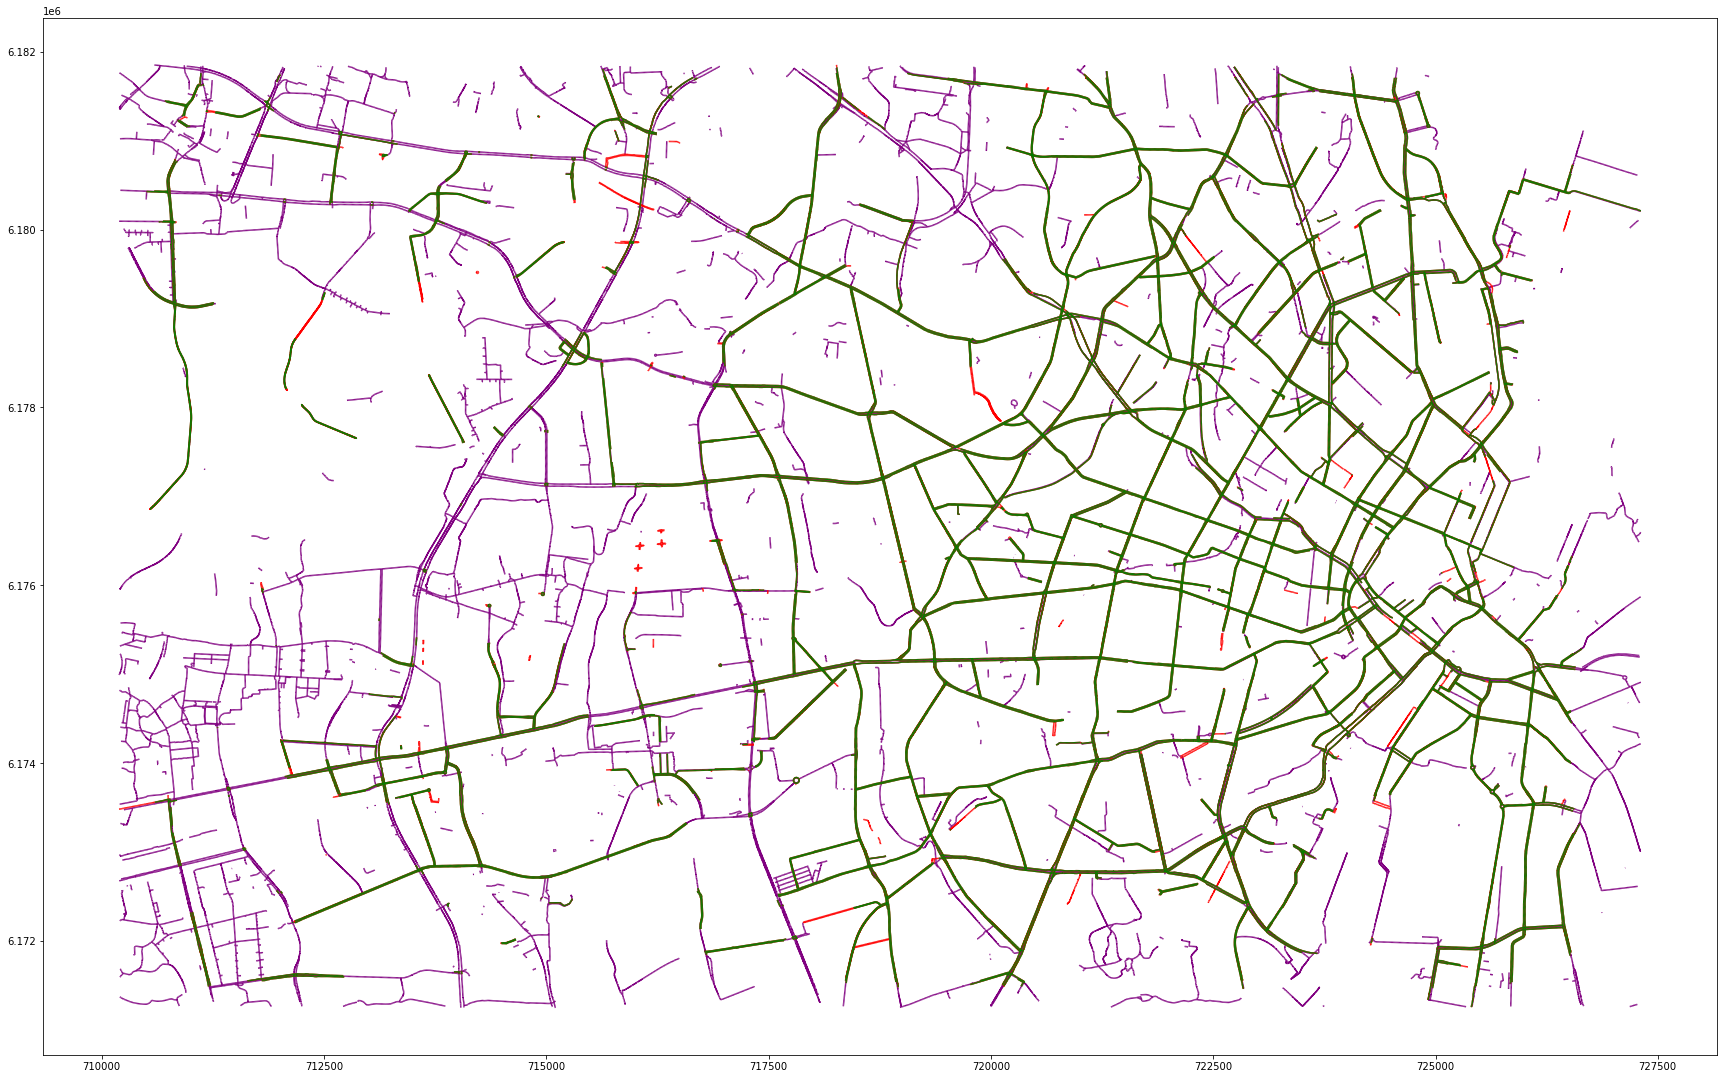

In [10]:
fig, ax = plt.subplots(figsize=(30,30))

osm_simplified_edges.plot(ax=ax, color='purple')
ref_simplified_edges.plot(ax=ax, color='red')
segment_matches.plot(ax=ax, color='green');

**Matched features in the reference data:**

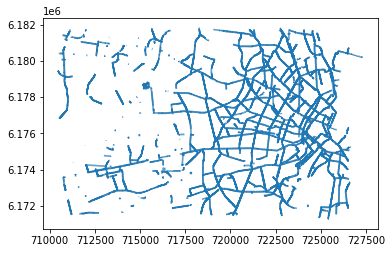

In [11]:
ref_matched_ids, ref_undec = mf.summarize_feature_matches(ref_segments, segment_matches, 'seg_id_ref','edge_id')
ref_simplified_edges.loc[ref_simplified_edges.edge_id.isin(ref_matched_ids)].plot();

**Matched features in the OSM data:**

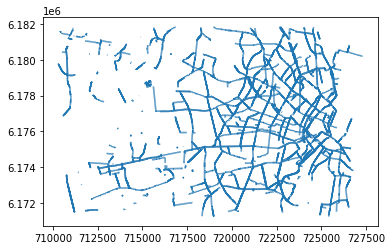

In [12]:
segment_matches['seg_id'] = segment_matches.matches_id
osm_matched_ids, osm_undec = mf.summarize_feature_matches(osm_segments, segment_matches,'seg_id','osmid')
osm_simplified_edges.loc[osm_simplified_edges.edge_id.isin(osm_matched_ids)].plot();

**Unmatched features in the OSM data:**

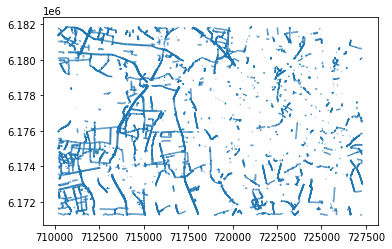

In [13]:
osm_simplified_edges.loc[~osm_simplified_edges.edge_id.isin(osm_matched_ids)].plot();

**Summarize results:**

In [14]:
count_matched_osm = len(osm_simplified_edges.loc[osm_simplified_edges.edge_id.isin(osm_matched_ids)])
count_matched_ref = len(ref_simplified_edges.loc[ref_simplified_edges.edge_id.isin(ref_matched_ids)])

print(f'Out of {len(osm_simplified_edges)} OSM edges, {count_matched_osm} were matched with a reference edge.')
print(f'Out of {len(ref_simplified_edges)} reference edges, {count_matched_ref} were matched with an OSM edge.')

length_matched_osm = osm_simplified_edges.loc[osm_simplified_edges.edge_id.isin(osm_matched_ids)].geometry.length.sum()
length_unmatched_osm = osm_simplified_edges.loc[~osm_simplified_edges.edge_id.isin(osm_matched_ids)].geometry.length.sum()

length_matched_ref = ref_simplified_edges.loc[ref_simplified_edges.edge_id.isin(ref_matched_ids)].geometry.length.sum()
length_unmatched_ref = ref_simplified_edges.loc[~ref_simplified_edges.edge_id.isin(ref_matched_ids)].geometry.length.sum()

print(f'Out of {osm_simplified_edges.geometry.length.sum()/1000:.2f} km of OSM edges, {length_matched_osm/1000:.2f} km were matched with a reference edge.')
print(f'Out of {ref_simplified_edges.geometry.length.sum()/1000:.2f} km of reference edges, {length_matched_ref/1000:.2f} km were matched with an OSM edge.')

results_feature_matching = {
    'osm_matched_count': count_matched_osm,
    'ref_matched_count': count_matched_ref,
    'osm_matched_length': length_matched_osm,
    'ref_matched_length': length_matched_ref
}

Out of 5437 OSM edges, 2466 were matched with a reference edge.
Out of 4208 reference edges, 3917 were matched with an OSM edge.
Out of 803.60 km of OSM edges, 420.57 km were matched with a reference edge.
Out of 623.52 km of reference edges, 600.58 km were matched with an OSM edge.


**Compare infrastructure type in matched features:**

In [15]:
updated_osm = mf.update_osm(osm_segments, osm_simplified_edges, segment_matches, 'protected', 'edge_id')

**Plotting edged marked as *protected* infrastructure in both datasets:** 

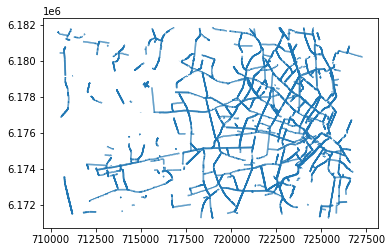

In [19]:
updated_osm.loc[updated_osm.protected == updated_osm.protected_matched].plot();

**Count and measure length of matched and unmatched features per grid cell:**

In [16]:
osm_matched = osm_edges_s_j.loc[osm_edges_s_j.edge_id.isin(osm_matched_ids)]

osm_unmatched = osm_edges_s_j.loc[~osm_edges_s_j.edge_id.isin(osm_matched_ids)]

# Count features in each grid cell
all_data_osm = [osm_matched, osm_unmatched]
labels_osm = ['osm_matched','osm_unmatched']

for data, label in zip(all_data_osm, labels_osm):

    df = ef.count_features_in_grid(data,label)

    grid = grid.merge(df, on='grid_id', how='left')

    df = ef.length_of_features_in_grid(data,label)

    grid = grid.merge(df, on='grid_id', how='left')
    

ref_matched = ref_edges_s_j.loc[ref_edges_s_j.edge_id.isin(ref_matched_ids)]
ref_unmatched = ref_edges_s_j.loc[~ref_edges_s_j.edge_id.isin(ref_matched_ids)]

# Count features in each grid cell
all_data_ref = [ref_matched, ref_unmatched]
labels_ref = ['ref_matched','ref_unmatched']

for data, label in zip(all_data_ref, labels_ref):

    df = ef.count_features_in_grid(data,label)

    grid = grid.merge(df, on='grid_id', how='left')

    df = ef.length_of_features_in_grid(data,label)

    grid = grid.merge(df, on='grid_id', how='left')

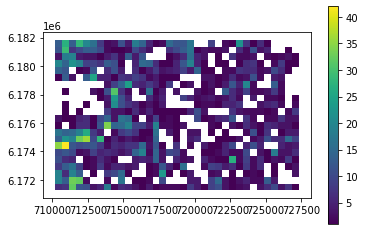

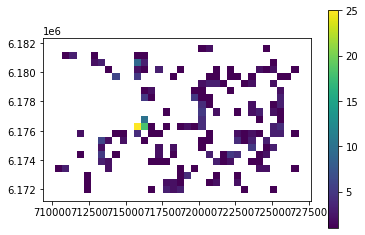

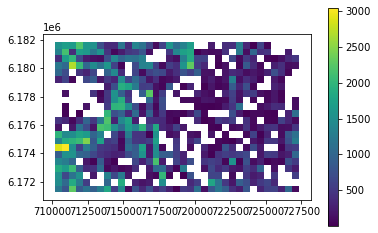

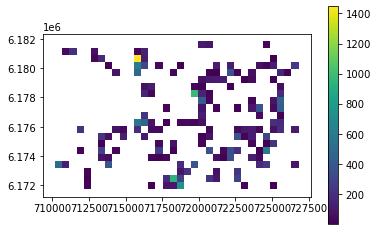

In [17]:
# TODO: Fix plots
grid.plot(column='count_osm_unmatched', legend=True);
grid.plot(column='count_ref_unmatched', legend=True);

grid.plot(column='length_osm_unmatched', legend=True);
grid.plot(column='length_ref_unmatched', legend=True);

In [18]:
with open(f'../results/extrinsic_analysis_{study_area}.json', 'w') as outfile:
    json.dump(results_feature_matching, outfile)


with open(f'../results/grid_results_feature_matching_{study_area}.pickle', 'wb') as f:
    pickle.dump(grid, f)